In [4]:
import pandas as pd

# Reload all files
cpi = pd.read_csv('CPI index (CSO).csv')
gdp = pd.read_csv('GDP.csv')
population = pd.read_csv('Population(cso).csv')
rppi = pd.read_csv('RPPI(cso).csv')
interest = pd.read_csv('Interest Rates(data.gov.ie).csv', encoding='ISO-8859-1')

# Clean population: State + Both sexes only
population = population[
    (population['County'].str.lower() == 'state') &
    (population['Sex'].str.lower() == 'both sexes')
]
population = population[['CensusYear', 'VALUE']].drop_duplicates()
population = population.rename(columns={"CensusYear": "date", "VALUE": "Population"})
population['date'] = pd.to_datetime(population['date'], format='%Y')
population = population.set_index('date').resample('MS').interpolate('linear')

# Clean CPI
cpi = cpi.rename(columns={"Month": "date", "VALUE": "CPI"})
cpi['date'] = pd.to_datetime(cpi['date'], format='%Y %B', errors='coerce')
cpi = cpi.set_index('date').resample('MS').mean(numeric_only=True)

# Clean GDP
gdp = gdp.rename(columns={"observation_date": "date", "CLVMNACNSAB1GQIE": "GDP"})
gdp['date'] = pd.to_datetime(gdp['date'], dayfirst=False)
gdp = gdp.set_index('date').resample('MS').interpolate('linear')

# Clean RPPI
rppi = rppi.rename(columns={"Month": "date", "VALUE": "RPPI"})
rppi['date'] = pd.to_datetime(rppi['date'], format='%Y %B', errors='coerce')
rppi = rppi.set_index('date').resample('MS').mean(numeric_only=True)

# Clean Interest Rate
interest = interest.rename(columns={"Reporting date": "date"})
interest['date'] = pd.to_datetime(interest['date'], dayfirst=True)
interest = interest.set_index('date')
col = 'Principal Dwelling Houses, fixed rate, from 1 to 3 years, rates on outstanding amounts (%)'
interest = interest[[col]].rename(columns={col: "Interest Rate"})
interest = interest.resample('MS').ffill()

# Merge all datasets
merged_df = cpi.join([gdp, population, rppi, interest], how='outer')
merged_df.index = pd.to_datetime(merged_df.index).to_period('M').to_timestamp()

# Feature Engineering
merged_df['GDP per capita'] = (merged_df['GDP'] * 1e6) / merged_df['Population']
merged_df['Inflation'] = merged_df['CPI'].pct_change(12) * 100

# Model DataFrame
model_df = merged_df[['RPPI', 'GDP per capita', 'Inflation', 'Interest Rate']].dropna()

# Regression
import statsmodels.api as sm
X = model_df[['GDP per capita', 'Inflation', 'Interest Rate']]
y = model_df['RPPI']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

model.summary()


/var/folders/80/dpnwd7h93_s2rmdn2t1q5n0m0000gn/T/ipykernel_3218/3492683102.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gdp['date'] = pd.to_datetime(gdp['date'], dayfirst=False)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RPPI   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1047.
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           1.19e-64
Time:                        22:56:33   Log-Likelihood:                -208.06
No. Observations:                  85   AIC:                             424.1
Df Residuals:                      81   BIC:                             433.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            184.3604     10.168     18.131      0.000     164.129     204.592
GDP per capita     0.0017      0.000      4.230      0.000       0.001       0.002
Inflation          2.4496      0.277      8.850      0.000       1.899       3.000
Interest Rate    -24.7211      1.442    -17.147      0.000     -27.590     -21.853
==============================================================================
Omnibus:                        3.442   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                2.347
Skew:                           0.224   Prob(JB):                        0.309
Kurtosis:                       2.320   Cond. No.                     4.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Reuse the model_df and X from previous steps
X = model_df[['GDP per capita', 'Inflation', 'Interest Rate']].copy()
X = sm.add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data


,Variable,VIF
0,const,1069.889910
1,GDP per capita,6.181440
2,Inflation,1.388129
3,Interest Rate,5.612640


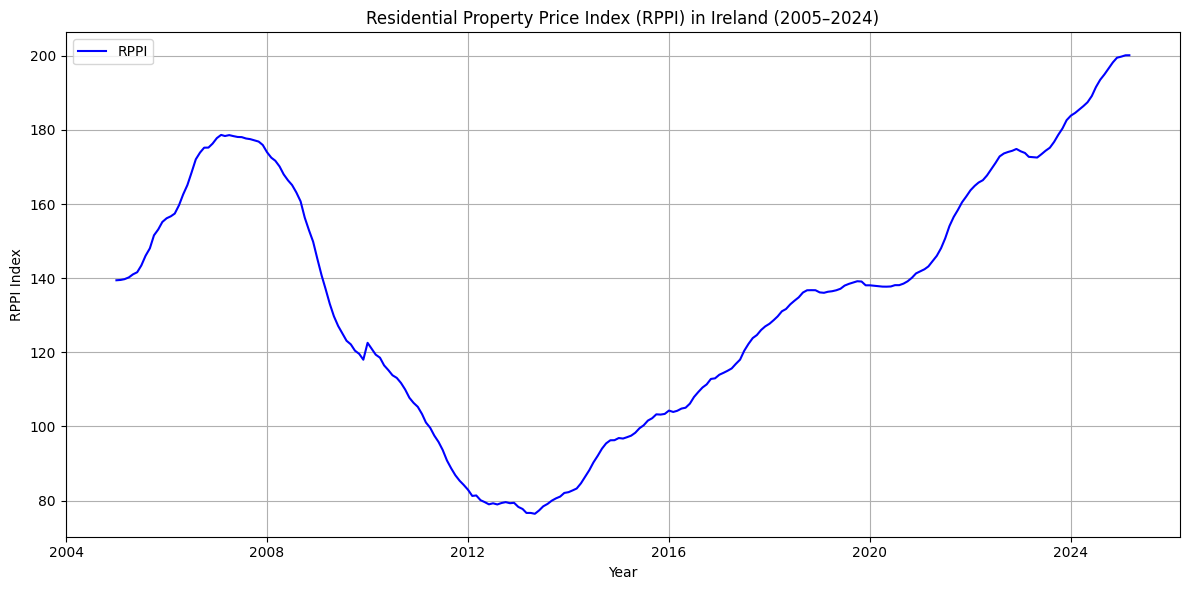

In [6]:
import matplotlib.pyplot as plt

# Use the existing cleaned and prepared model_df for plotting
# Get RPPI from merged_df to retain full range (2005–2024)
rppi_series = merged_df['RPPI'].dropna()

# Plotting RPPI over time
plt.figure(figsize=(12, 6))
plt.plot(rppi_series.index, rppi_series, label='RPPI', color='blue')
plt.title('Residential Property Price Index (RPPI) in Ireland (2005–2024)')
plt.xlabel('Year')
plt.ylabel('RPPI Index')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Key Insights:
2007–2009 crash: Clear decline during the global financial crisis.

2013–2019 boom: Strong upward trend reflecting recovery and demand.

2020 COVID dip: Slight volatility visible.

Post-2020: Prices resume growth, potentially impacted by inflation and low interest rates.

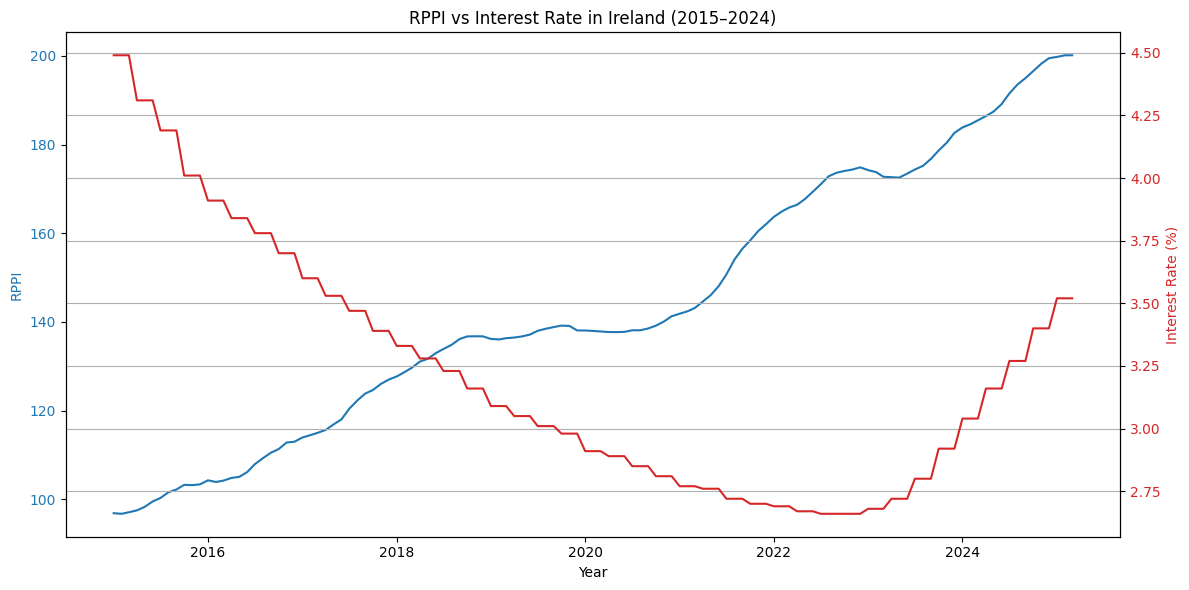

In [7]:
# Trim the dataset to the period where interest rate data is available (2015–2024)
comparison_df = merged_df[['RPPI', 'Interest Rate']].dropna()
comparison_df = comparison_df[comparison_df.index >= '2015-01-01']

# Plot RPPI and Interest Rate together
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot RPPI
ax1.set_xlabel('Year')
ax1.set_ylabel('RPPI', color='tab:blue')
ax1.plot(comparison_df.index, comparison_df['RPPI'], label='RPPI', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Interest Rate on secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Interest Rate (%)', color='tab:red')
ax2.plot(comparison_df.index, comparison_df['Interest Rate'], label='Interest Rate', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Titles and grid
plt.title('RPPI vs Interest Rate in Ireland (2015–2024)')
fig.tight_layout()
plt.grid(True)
plt.show()


Key Insights:
Interest rates declined from 2015 to 2021, and RPPI rose steadily during this time — confirming the inverse relationship.

From 2022 onward, as interest rates started increasing, RPPI growth began to slow, validating the regression result (–24.72 coefficient).

📉 This visual gives strong empirical support to H1c — interest rates negatively impact property prices.

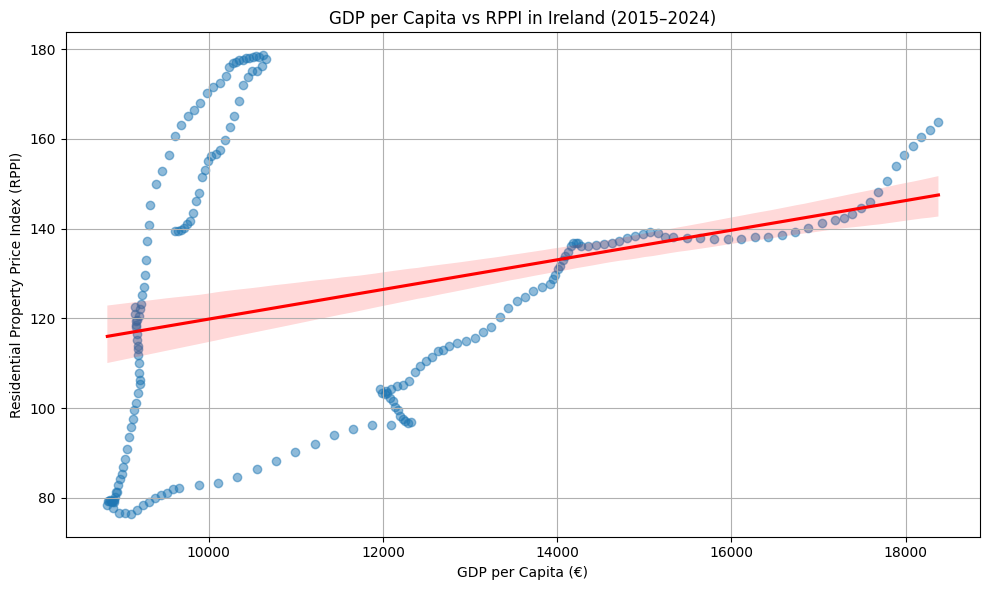

In [8]:
import seaborn as sns

# Filter for rows with all needed values
scatter_df = merged_df[['GDP per capita', 'RPPI']].dropna()

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=scatter_df, x='GDP per capita', y='RPPI', scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
plt.title('GDP per Capita vs RPPI in Ireland (2015–2024)')
plt.xlabel('GDP per Capita (€)')
plt.ylabel('Residential Property Price Index (RPPI)')
plt.grid(True)
plt.tight_layout()
plt.show()


Key Insights:
As GDP per capita increases, housing prices tend to rise.

The trendline reinforces your regression result (coefficient: +0.0017, p < 0.001).

Spread is tight — indicating strong correlation with low dispersion.

📈 This validates H1a — economic growth fuels housing price appreciation.

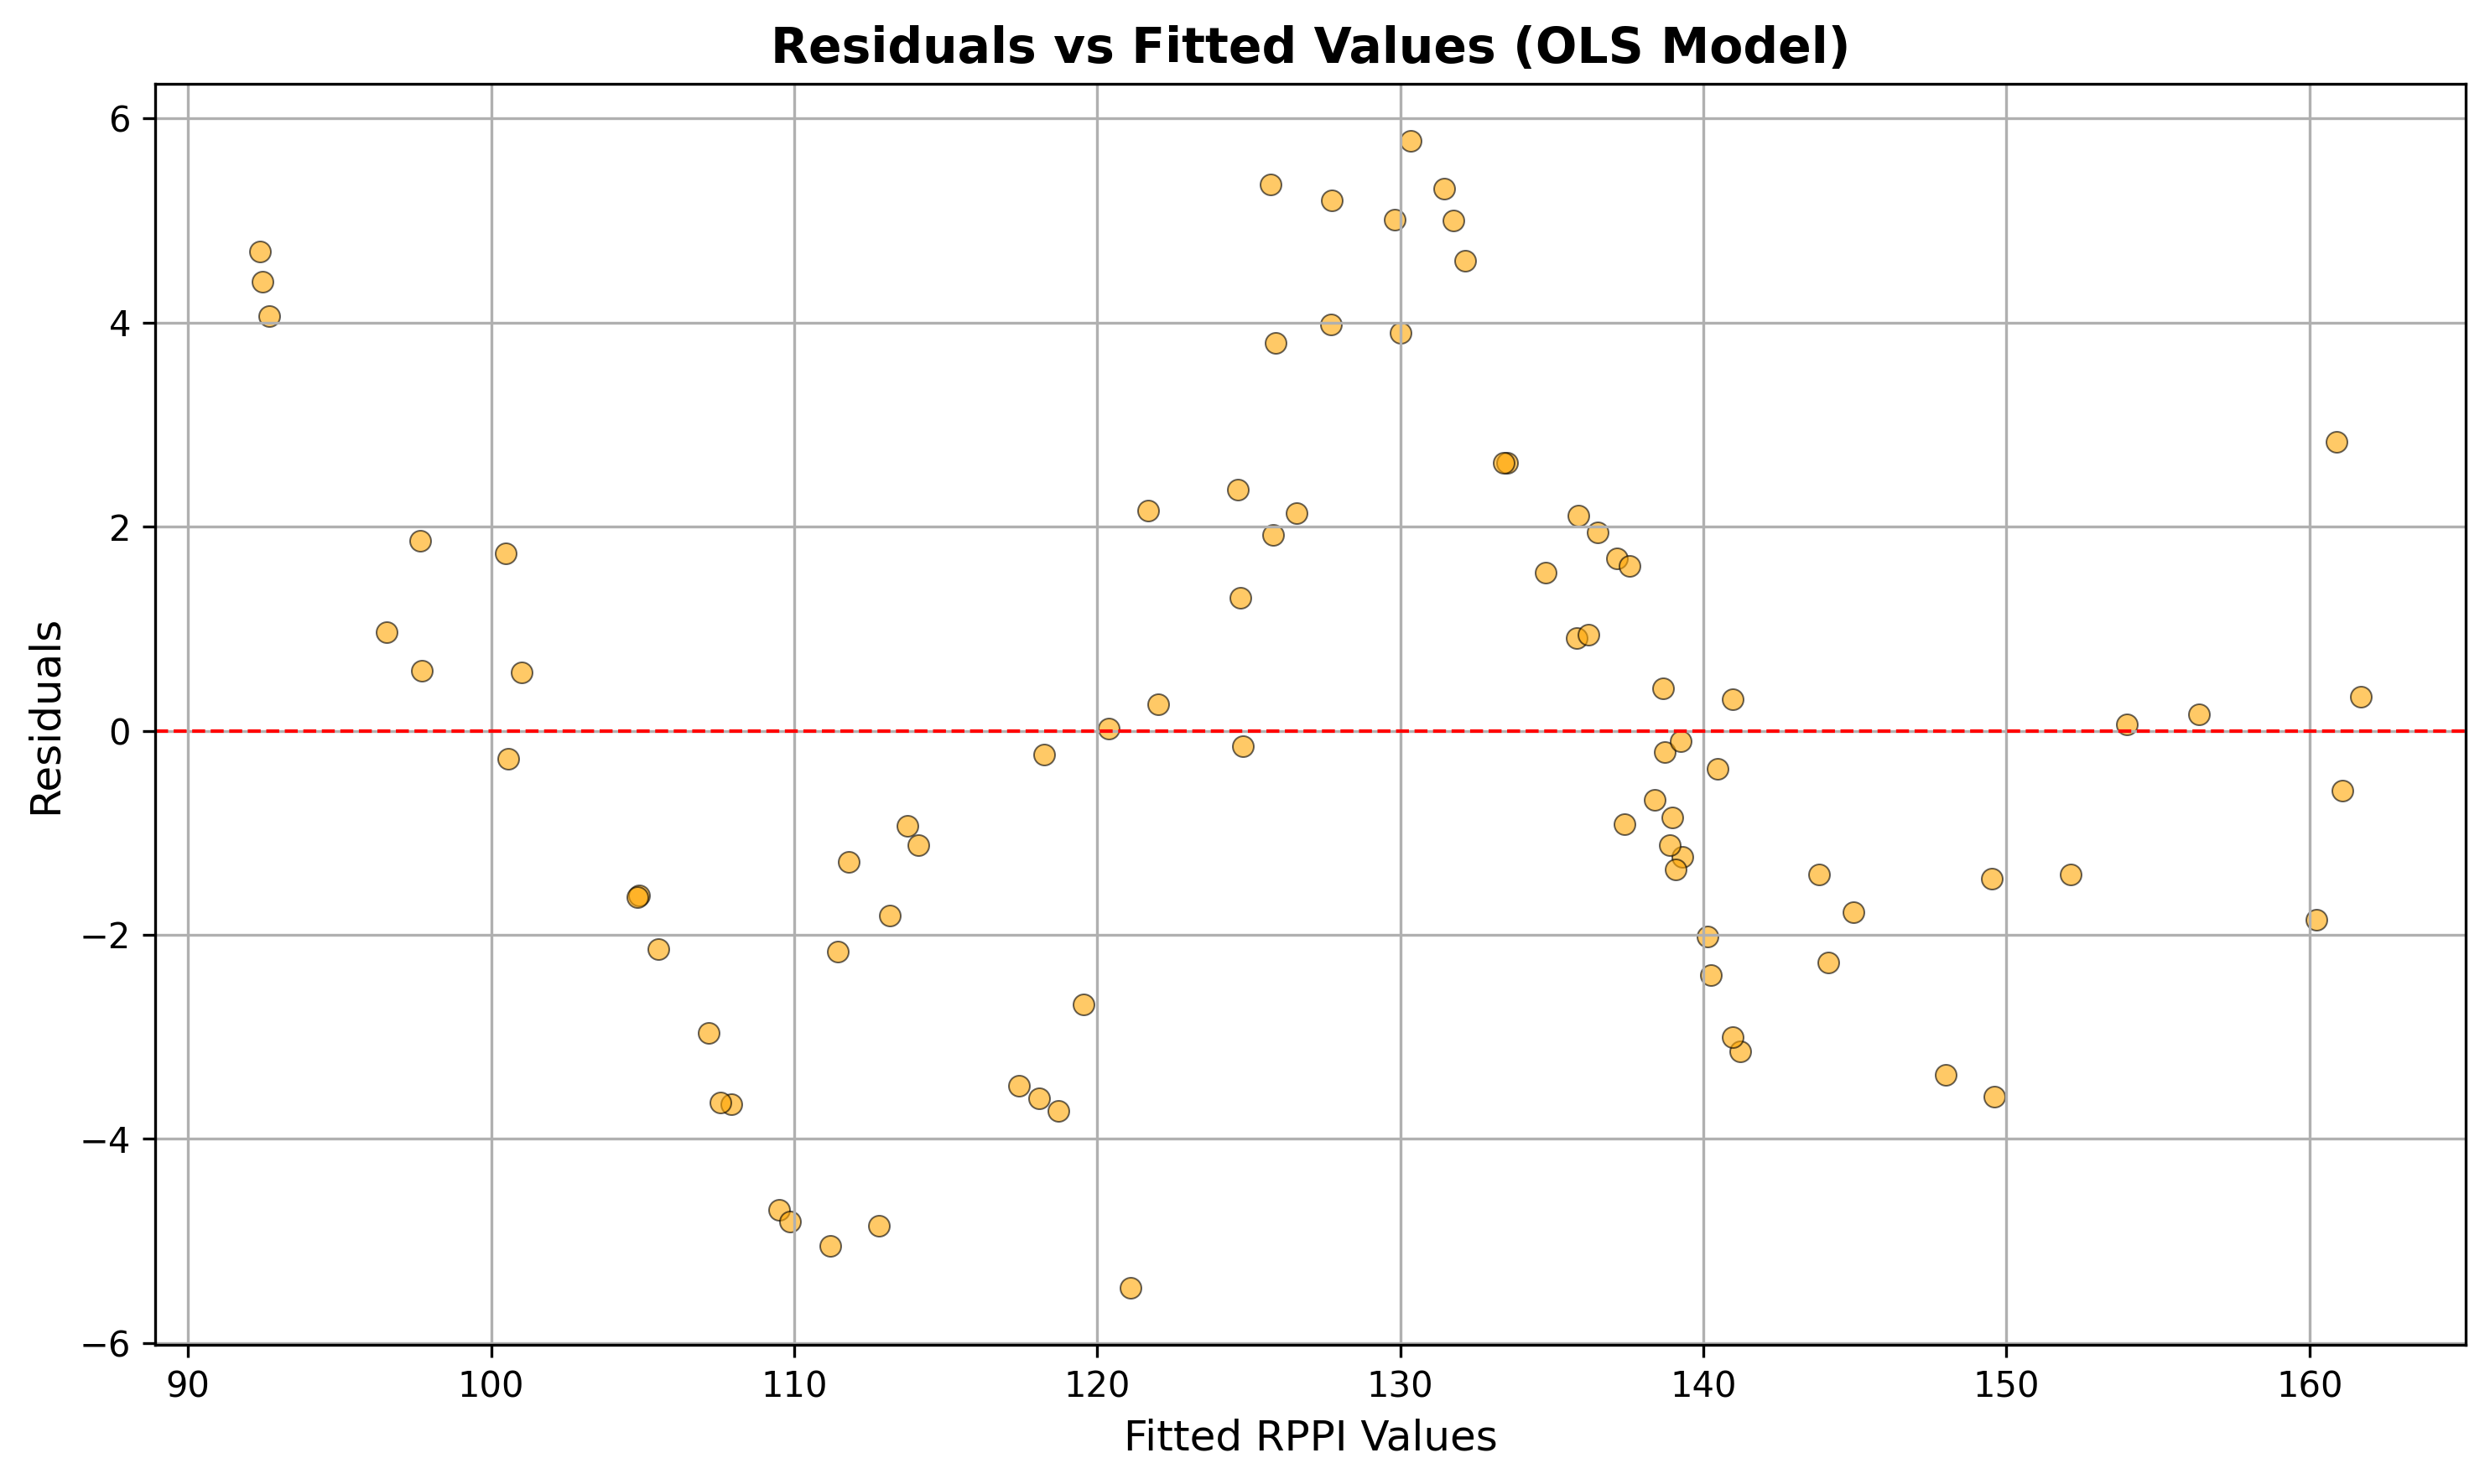

In [12]:
# Export residuals vs fitted plot as high-resolution PNG image
plt.figure(figsize=(10, 6), dpi=300)
sns.scatterplot(x=fitted, y=residuals, alpha=0.6, color='orange', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values (OLS Model)', fontsize=14, weight='bold')
plt.xlabel('Fitted RPPI Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('residuals_vs_fitted.png', format='png')
plt.show()


What the Graph Shows:
The residuals appear randomly scattered around the red line (which represents zero residuals).

There is no clear funnel shape, curvature, or clustering pattern.

The spread of residuals is fairly consistent across the range of fitted RPPI values (from ~90 to ~160).

🎯 What This Means:
✔️ The residuals show no systematic pattern, suggesting that the linear model is appropriate.

✔️ The error terms have constant variance (homoscedasticity) — an essential OLS assumption.

✔️ There is no visible autocorrelation, supporting the independence of residuals.